In [1]:
%%capture
!pip install datasets

In [34]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from tqdm import tqdm
import random
import os

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [3]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [4]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

C:\Users\Alexandru\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alexandru\.cache\huggingface\hub\datasets--scikit-fingerprints--MoleculeNet_Lipophilicity. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|█████████████████████████████

# EDA

In [5]:
dataset['train']

Dataset({
    features: ['SMILES', 'label'],
    num_rows: 4200
})

In [6]:
max([len(a) for a in dataset['train']['SMILES']])

267

In [7]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here
data=dataset['train'].to_pandas()
data.head()

SMILES  label
0            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   3.54
1  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...  -1.18
2             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   3.69
3  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   3.37
4  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...   3.10

In [8]:
min([len(a) for a in data.SMILES])

11

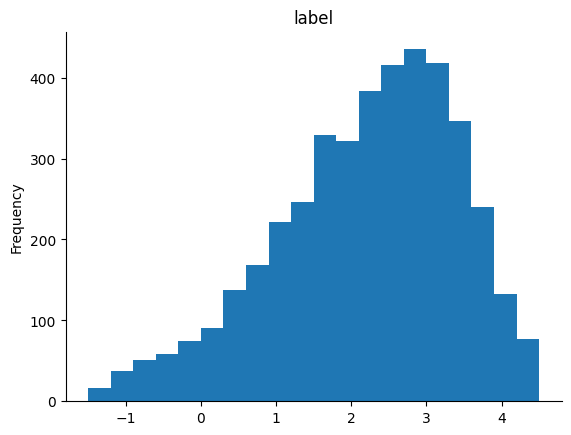

In [9]:
# @title label

from matplotlib import pyplot as plt
data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
data.nunique()

SMILES    4200
label      553
dtype: int64

In [11]:
data.isnull().sum()

SMILES    0
label     0
dtype: int64

### Some EDA

In [19]:
ert=SMILESDataset(data.SMILES,data.label,tokenizer)
qwe=[len(ert.smiles[a]) for a in range(len(ert))]
max(qwe)

267

In [20]:
bin_cts=pd.cut(qwe,bins=20).value_counts().sort_index()
bin_cts=bin_cts[bin_cts>0]
df = pd.DataFrame({
    'Bin Range': bin_cts.index,
    'Frequency': bin_cts.values
})

# Add a cumulative column
df['Cumulative Frequency'] = df['Frequency'].cumsum()
df

Bin Range  Frequency  Cumulative Frequency
0   (10.744, 23.8]        174                   174
1     (23.8, 36.6]        897                  1071
2     (36.6, 49.4]       1228                  2299
3     (49.4, 62.2]       1319                  3618
4     (62.2, 75.0]        452                  4070
5     (75.0, 87.8]        102                  4172
6    (87.8, 100.6]         16                  4188
7   (100.6, 113.4]          3                  4191
8   (113.4, 126.2]          2                  4193
9   (126.2, 139.0]          1                  4194
10  (139.0, 151.8]          2                  4196
11  (151.8, 164.6]          1                  4197
12  (177.4, 190.2]          1                  4198
13  (241.4, 254.2]          1                  4199
14  (254.2, 267.0]          1                  4200

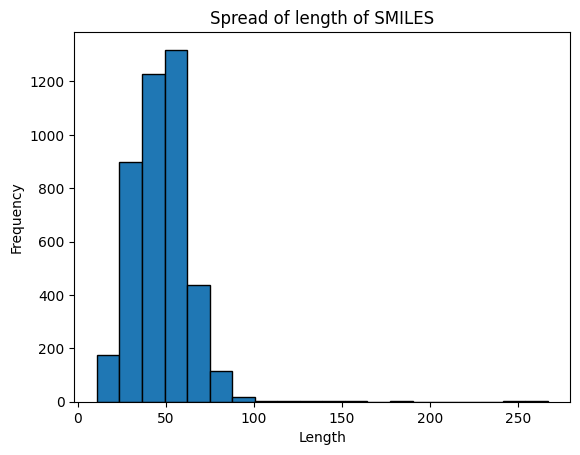

In [21]:
import matplotlib.pyplot as plt
import numpy as np
hist, bin_edges = np.histogram(qwe, bins=20)

# Plot the bar plot
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
plt.title('Spread of length of SMILES')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Necessary blocks

In [13]:
# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
class SMILESDataset(Dataset):
  def __init__(self,smiles,labels,tokenizer=None) -> None:
    super().__init__()
    self.smiles=smiles
    self.labels=labels
    self.tokenizer=tokenizer

  def __len__(self):
    return len(self.smiles)

  def __getitem__(self,idx):
    sample_smiles,sample_label=self.smiles[idx],self.labels[idx]
    sample_label=torch.tensor(sample_label,dtype=torch.float32)

    if self.tokenizer:
      encoded_smiles=self.tokenizer(sample_smiles, padding=True, max_length=268, truncation=True, return_tensors="pt")
      sample_smiles = encoded_smiles['input_ids'].squeeze(0)
      attention_mask=encoded_smiles['attention_mask'].squeeze(0)

    return {'input_ids':sample_smiles,'attention_mask':attention_mask,'label':sample_label}

In [14]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

C:\Users\Alexandru\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alexandru\.cache\huggingface\hub\models--ibm--MoLFormer-XL-both-10pct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
A new version of the following files was downloaded from https://huggingface.c

In [15]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [16]:
# split the data into training and test datasets
# TODO: your code goes here
X_train,X_test,y_train,y_test=train_test_split(dataset['train']['SMILES'],dataset['train']['label'],test_size=0.2,random_state=42)

In [17]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False, # Set to False for supervised training
    mlm_probability=0.15 # Only used if mlm=True
)

In [18]:
# construct Pytorch data loaders for both train and test datasets
# TODO: your code goes here
BATCH_SIZE = 16 # adjust based on memory constraints
train_loader=DataLoader(SMILESDataset(X_train,y_train,tokenizer),batch_size=BATCH_SIZE,shuffle=True,collate_fn=data_collator)
test_loader=DataLoader(SMILESDataset(X_test,y_test,tokenizer),batch_size=BATCH_SIZE,shuffle=False,collate_fn=data_collator)

# Fine tuning techniques

## LoRA class

In [22]:
class LoRALinear(nn.Module):
    def __init__(self, base_linear, r=4, alpha=1.0, dropout=0.1):
        super().__init__()
        self.r=r
        self.alpha=alpha
        self.base_linear = base_linear
        self.dropout = nn.Dropout(dropout)

        for param in self.base_linear.parameters():
          param.requires_grad=False

        # Dimensions from the base linear layer
        in_features = base_linear.in_features
        out_features = base_linear.out_features

        # Initialize the LoRA parameters: A and B such that ΔW = A B.
        # They are initialized with small random values.
        self.lora_A = nn.Parameter(torch.randn(r, in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(out_features, r) * 0.01)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: compute original linear output plus LoRA adaptation.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features).
        """
        # Original output from the frozen weight
        output = self.base_linear(x)

        # LoRA contribution: apply dropout to x, then low-rank adaptation.
        lora_out = self.lora_B @ (self.lora_A @ self.dropout(x).T)
        lora_out = lora_out.T  # shape: (batch_size, out_features)

        # Scale the LoRA output (scaling by alpha / r is common in LoRA)
        lora_out = lora_out * (self.alpha / self.r)

        return output + lora_out

## BitFit function

In [23]:
def bitfit(model):
  for name,param in model.named_parameters():
    if 'bias' not in name:
      param.requires_grad=False

## IA3 class

In [24]:
class IA3Adapter(nn.Module):
    def __init__(self, hidden_size):#, adapter_size=32):
        super().__init__()
        # self.adapter = nn.Linear(hidden_size, adapter_size)
        self.scale=nn.Parameter(torch.ones(hidden_size))

    def forward(self, hidden_states):
        return hidden_states * self.scale

# Backbone

In [25]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    # TODO: your code goes here
    def __init__(self,model,PEFT_type=None,r=4,alpha=1.0,dropout=0.1): # r and alpha are only for LoRA
        super().__init__()

        self.lang_model=model
        hidden_size=self.lang_model.config.hidden_size

        self.dropout=nn.Dropout(dropout)
        self.regression_head=nn.Linear(hidden_size,1)

        if PEFT_type=='LoRA':
          self.regression_head = LoRALinear(self.regression_head, r=r, alpha=alpha, dropout=dropout)

        elif PEFT_type=='BitFit':
          bitfit(self)

        elif PEFT_type=='IA3':
          self.adapter=IA3Adapter(hidden_size)#,adapter_size=r)


    def forward(self, input_ids, attention_mask=None,labels=None):
        outputs=self.lang_model(input_ids=input_ids,attention_mask=attention_mask)

        if hasattr(outputs,'pooler_output') and outputs.pooler_output is not None:
          pooled_output=outputs.pooler_output
        else:
          pooled_output=outputs.last_hidden_state[:,0,:]

        pooled_output=self.dropout(pooled_output)

        #In case of IA3
        if hasattr(self,'adapter'):
          pooled_output=self.adapter(pooled_output)

        regression_output=self.regression_head(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = loss_fn(regression_output.view(-1), labels.view(-1))

        return (loss, regression_output) if loss is not None else regression_output

In [26]:
# initialize the regression model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model).to(device) # Base model

In [27]:
def get_train_loader(current_epoch, total_epochs, batch_size=32,data_selection_type=None):
  if data_selection_type=='curriculum':
    return curriculum_learning_dataloader(
        SMILESDataset(X_train,y_train,tokenizer),
        current_epoch,
        total_epochs,
        batch_size)
  elif data_selection_type=='active':
    return active_learning_loader
  return train_loader

In [28]:
# TODO: your code goes here
def trainer(model, optimiser, epochs, data_selection_type=None):
  for epoch in range(1,epochs+1):
    model.train()
    total_loss,batch_count=0.0,0
    train_loader=get_train_loader(epoch, epochs, BATCH_SIZE,data_selection_type)

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
      input_ids=batch['input_ids'].to(device)
      labels=batch['label'].to(device)
      attention_mask=batch['attention_mask'].to(device)

      optimiser.zero_grad()

      loss,predictions=model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)

      loss.backward()
      optimiser.step()

      total_loss+=loss.item()
      batch_count+=1

    avg_loss = total_loss / batch_count if batch_count > 0 else float('inf')
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")
  return avg_loss

In [29]:
# TODO: your code goes here

def evaluator(model, test_loader):
  # Switch the model to evaluation mode
  model.eval()

  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for batch in test_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          # Get predictions (no loss is computed here as we don't pass labels)
          predictions = model(input_ids=input_ids,attention_mask=attention_mask)
          # Accessing the predicted values from the output tuple
          all_predictions.extend(predictions.cpu().detach().numpy().flatten())
          all_labels.extend(labels.cpu().numpy().flatten())

  # Calculate evaluation metrics
  mse = mean_squared_error(all_labels, all_predictions)
  r2 = r2_score(all_labels, all_predictions)

  print(f"Evaluation MSE: {mse}")
  print(f"Evaluation R² Score: {r2}")
  return {'mse':mse,'r2':r2}

## Baseline model

In [30]:
epochs=5
optimiser=torch.optim.Adam(regression_model.parameters(),lr=1e-4)

In [35]:
trainer(regression_model,optimiser,epochs)



Epoch 1:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 1:   0%|▎                                                                        | 1/210 [00:01<05:19,  1.53s/it]

Epoch 1:   1%|▋                                                                        | 2/210 [00:02<04:37,  1.33s/it]

Epoch 1:   1%|█                                                                        | 3/210 [00:03<03:57,  1.15s/it]

Epoch 1:   2%|█▍                                                                       | 4/210 [00:04<03:35,  1.04s/it]

Epoch 1:   2%|█▋                                                                       | 5/210 [00:05<03:19,  1.03it/s]

Epoch 1:   3%|██                                                                       | 6/210 [00:06<03:28,  1.02s/it]

Epoch 1:   3%|██▍                                                                      | 7/210 [00:07<03:25,  1.01s/it]

Epoch 1:   4%|██▊             

Epoch 1 - Average Loss: 0.8938




Epoch 2:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 2:   0%|▎                                                                        | 1/210 [00:00<03:03,  1.14it/s]

Epoch 2:   1%|▋                                                                        | 2/210 [00:01<02:58,  1.16it/s]

Epoch 2:   1%|█                                                                        | 3/210 [00:02<02:50,  1.22it/s]

Epoch 2:   2%|█▍                                                                       | 4/210 [00:03<03:01,  1.14it/s]

Epoch 2:   2%|█▋                                                                       | 5/210 [00:04<03:05,  1.10it/s]

Epoch 2:   3%|██                                                                       | 6/210 [00:05<03:21,  1.01it/s]

Epoch 2:   3%|██▍                                                                      | 7/210 [00:06<03:15,  1.04it/s]

Epoch 2:   4%|██▊             

Epoch 2 - Average Loss: 0.4729




Epoch 3:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 3:   0%|▎                                                                        | 1/210 [00:01<03:30,  1.01s/it]

Epoch 3:   1%|▋                                                                        | 2/210 [00:01<03:17,  1.05it/s]

Epoch 3:   1%|█                                                                        | 3/210 [00:02<03:16,  1.05it/s]

Epoch 3:   2%|█▍                                                                       | 4/210 [00:03<03:13,  1.07it/s]

Epoch 3:   2%|█▋                                                                       | 5/210 [00:04<03:05,  1.11it/s]

Epoch 3:   3%|██                                                                       | 6/210 [00:05<03:12,  1.06it/s]

Epoch 3:   3%|██▍                                                                      | 7/210 [00:06<03:06,  1.09it/s]

Epoch 3:   4%|██▊             

Epoch 3 - Average Loss: 0.3387




Epoch 4:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 4:   0%|▎                                                                        | 1/210 [00:01<03:37,  1.04s/it]

Epoch 4:   1%|▋                                                                        | 2/210 [00:01<03:25,  1.01it/s]

Epoch 4:   1%|█                                                                        | 3/210 [00:02<03:12,  1.08it/s]

Epoch 4:   2%|█▍                                                                       | 4/210 [00:03<03:04,  1.12it/s]

Epoch 4:   2%|█▋                                                                       | 5/210 [00:04<03:13,  1.06it/s]

Epoch 4:   3%|██                                                                       | 6/210 [00:05<03:16,  1.04it/s]

Epoch 4:   3%|██▍                                                                      | 7/210 [00:06<03:19,  1.02it/s]

Epoch 4:   4%|██▊             

Epoch 4 - Average Loss: 0.2561




Epoch 5:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 5:   0%|▎                                                                        | 1/210 [00:00<02:49,  1.23it/s]

Epoch 5:   1%|▋                                                                        | 2/210 [00:01<03:07,  1.11it/s]

Epoch 5:   1%|█                                                                        | 3/210 [00:02<03:22,  1.02it/s]

Epoch 5:   2%|█▍                                                                       | 4/210 [00:03<03:14,  1.06it/s]

Epoch 5:   2%|█▋                                                                       | 5/210 [00:04<03:06,  1.10it/s]

Epoch 5:   3%|██                                                                       | 6/210 [00:05<03:05,  1.10it/s]

Epoch 5:   3%|██▍                                                                      | 7/210 [00:06<03:04,  1.10it/s]

Epoch 5:   4%|██▊             

Epoch 5 - Average Loss: 0.2170


0.2169924904193197

In [36]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.5024191848979285
Evaluation R² Score: 0.65994730373426


{'mse': 0.5024191848979285, 'r2': 0.65994730373426}

In [37]:
# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]

# for epoch in epochs_list:
#   for lr in lr_list:
#     optimiser=torch.optim.Adam(regression_model.parameters(),lr=lr)
#     final_loss_per_lr.append(trainer(regression_model,optimiser,epoch))
#     metrics_per_lr.append(evaluator(regression_model,test_loader))
#   final_losses.append(final_loss_per_lr)
#   metrics.append(metrics_per_lr)
#   final_loss_per_lr=[]
#   metrics_per_lr=[]
# # trainer(regression_model,optimiser,train_loader,epochs)

In [38]:
# final_losses=final_losses[0]
# metrics=metrics[0]

In [39]:
# final_losses

In [40]:
# metrics

# Data selection methods

In [41]:
# from google.colab import files
# uploaded=files.upload()

In [42]:
# smalldata=pd.read_csv('/content/External-Dataset_for_Task2.csv')
# smalldata.head()

## Curriculum learning

In [43]:
def difficulty(data):
  return [len(data.smiles[a]) for a in range(len(data))]

In [44]:
def idx_selector(data, diff_scores, epoch, total_epochs, min_diff, max_diff):
  current_threshold=min_diff+(max_diff-min_diff)*(epoch/total_epochs)
  print(current_threshold)
  selected_indices = [i for i, diff in enumerate(diff_scores) if diff <= current_threshold]
  return selected_indices

In [45]:
def curriculum_learning_dataloader(data, current_epoch, total_epochs, batch_size=32):
  difficulty_scores=difficulty(data)
  min_diff,max_diff=min(difficulty_scores),max(difficulty_scores)

  selected_idx=idx_selector(data,difficulty_scores,current_epoch,total_epochs,min_diff,max_diff)

  print(f"Curriculum Epoch {current_epoch}: Using {len(selected_idx)}/{len(data)} samples")
  return DataLoader(Subset(data, selected_idx), batch_size=batch_size, collate_fn=data_collator,shuffle=True)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model).to(device) # Base model

In [47]:
# Run this only when you want to do some more epochs and learning rates

# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]

# for epoch in epochs_list:
#   for lr in lr_list:
#     optimiser=torch.optim.Adam(regression_model.parameters(),lr=lr)
#     final_loss_per_lr.append(trainer(regression_model,optimiser,epoch,data_selection_type='curriculum'))
#     metrics_per_lr.append(evaluator(regression_model,test_loader))
#   final_losses.append(final_loss_per_lr)
#   print(f'for epoch {epoch} and learning rates {lr_list} final losses are {final_loss_per_lr}')
#   metrics.append(metrics_per_lr)
#   print(f'for epoch {epoch} and learning rates {lr_list} MSE and R2 are {metrics_per_lr}')
#   final_loss_per_lr=[]
#   metrics_per_lr=[]

In [48]:
# final_losses

In [49]:
# metrics

In [50]:
epochs=5
batch_size=32
trainer(regression_model,optimiser,epochs,data_selection_type='curriculum')

62.2
Curriculum Epoch 1: Using 2899/3360 samples




Epoch 1:   0%|                                                                                 | 0/182 [00:00<?, ?it/s]

Epoch 1:   1%|▍                                                                        | 1/182 [00:00<02:45,  1.09it/s]

Epoch 1:   1%|▊                                                                        | 2/182 [00:01<02:34,  1.16it/s]

Epoch 1:   2%|█▏                                                                       | 3/182 [00:02<02:31,  1.18it/s]

Epoch 1:   2%|█▌                                                                       | 4/182 [00:03<02:28,  1.20it/s]

Epoch 1:   3%|██                                                                       | 5/182 [00:04<02:26,  1.21it/s]

Epoch 1:   3%|██▍                                                                      | 6/182 [00:04<02:23,  1.23it/s]

Epoch 1:   4%|██▊                                                                      | 7/182 [00:05<02:21,  1.23it/s]

Epoch 1:   4%|███▏            

Epoch 1 - Average Loss: 0.3216
113.4
Curriculum Epoch 2: Using 3354/3360 samples




Epoch 2:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 2:   0%|▎                                                                        | 1/210 [00:01<03:48,  1.10s/it]

Epoch 2:   1%|▋                                                                        | 2/210 [00:02<03:28,  1.00s/it]

Epoch 2:   1%|█                                                                        | 3/210 [00:03<03:30,  1.02s/it]

Epoch 2:   2%|█▍                                                                       | 4/210 [00:04<03:35,  1.05s/it]

Epoch 2:   2%|█▋                                                                       | 5/210 [00:05<03:39,  1.07s/it]

Epoch 2:   3%|██                                                                       | 6/210 [00:06<03:30,  1.03s/it]

Epoch 2:   3%|██▍                                                                      | 7/210 [00:07<03:16,  1.03it/s]

Epoch 2:   4%|██▊             

Epoch 2 - Average Loss: 0.2065
164.6
Curriculum Epoch 3: Using 3358/3360 samples




Epoch 3:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 3:   0%|▎                                                                        | 1/210 [00:00<03:00,  1.16it/s]

Epoch 3:   1%|▋                                                                        | 2/210 [00:01<03:07,  1.11it/s]

Epoch 3:   1%|█                                                                        | 3/210 [00:02<03:21,  1.03it/s]

Epoch 3:   2%|█▍                                                                       | 4/210 [00:03<03:12,  1.07it/s]

Epoch 3:   2%|█▋                                                                       | 5/210 [00:04<03:07,  1.09it/s]

Epoch 3:   3%|██                                                                       | 6/210 [00:05<03:10,  1.07it/s]

Epoch 3:   3%|██▍                                                                      | 7/210 [00:06<03:01,  1.12it/s]

Epoch 3:   4%|██▊             

Epoch 3 - Average Loss: 0.1604
215.8
Curriculum Epoch 4: Using 3358/3360 samples




Epoch 4:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 4:   0%|▎                                                                        | 1/210 [00:00<02:44,  1.27it/s]

Epoch 4:   1%|▋                                                                        | 2/210 [00:01<03:05,  1.12it/s]

Epoch 4:   1%|█                                                                        | 3/210 [00:02<02:58,  1.16it/s]

Epoch 4:   2%|█▍                                                                       | 4/210 [00:03<02:53,  1.19it/s]

Epoch 4:   2%|█▋                                                                       | 5/210 [00:04<03:06,  1.10it/s]

Epoch 4:   3%|██                                                                       | 6/210 [00:05<02:57,  1.15it/s]

Epoch 4:   3%|██▍                                                                      | 7/210 [00:06<02:59,  1.13it/s]

Epoch 4:   4%|██▊             

Epoch 4 - Average Loss: 0.1348
267.0
Curriculum Epoch 5: Using 3360/3360 samples




Epoch 5:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 5:   0%|▎                                                                        | 1/210 [00:00<03:12,  1.08it/s]

Epoch 5:   1%|▋                                                                        | 2/210 [00:01<03:04,  1.13it/s]

Epoch 5:   1%|█                                                                        | 3/210 [00:02<03:06,  1.11it/s]

Epoch 5:   2%|█▍                                                                       | 4/210 [00:03<03:09,  1.09it/s]

Epoch 5:   2%|█▋                                                                       | 5/210 [00:04<03:32,  1.04s/it]

Epoch 5:   3%|██                                                                       | 6/210 [00:05<03:19,  1.02it/s]

Epoch 5:   3%|██▍                                                                      | 7/210 [00:06<03:14,  1.04it/s]

Epoch 5:   4%|██▊             

Epoch 5 - Average Loss: 0.1199


0.11991694038290353

In [51]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.4005918709982091
Evaluation R² Score: 0.7288671493252126


{'mse': 0.4005918709982091, 'r2': 0.7288671493252126}

## Active learning via uncertainty sampling

In [52]:
def uncertain_samples(model, vanilla_loader,num_samples,device,num_forw_pass):
    """
    Selects samples with the highest predictive uncertainty using Monte Carlo dropout.

    Args:
        model: The trained regression model.
        vanilla_loader: DataLoader for the unlabeled or full dataset.
        num_samples: The number of uncertain samples to select.
        device: torch.device (e.g., "cuda" or "cpu").
        num_forw_pass: Number of forward passes for uncertainty estimation.

    Returns:
        A list of indices corresponding to the most uncertain samples.
    """
    model.train() #So according to the active learning principal, model is used in training mode for dropout to be active
    uncertainties = []  # To store uncertainty values per sample.
    sample_indices = []  # To keep track of sample indices.

    with torch.no_grad():
        for batch_idx, batch in enumerate(vanilla_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_size = input_ids.size(0)

            predictions_list = []
            for _ in range(num_forw_pass):
                # shape (batch_size, 1)
                preds = model(input_ids=input_ids, attention_mask=attention_mask)
                predictions_list.append(preds[1])

            # shape (num_forward_passes, batch_size, 1)
            predictions_stack = torch.stack(predictions_list, dim=0)

            std_preds = predictions_stack.std(dim=0)#.squeeze(-1)  # shape: (batch_size,)

            uncertainties.extend(std_preds.cpu().tolist())

            batch_indices = list(range(batch_idx * batch_size, batch_idx * batch_size + batch_size))
            sample_indices.extend(batch_indices)

    # Sort sample indices by uncertainty in descending order.
    sorted_indices = sorted(range(len(uncertainties)), key=lambda i: uncertainties[i], reverse=True)
    selected_indices = [sample_indices[i] for i in sorted_indices[:num_samples]]

    return selected_indices

In [53]:
selected_idx=uncertain_samples(regression_model,train_loader,num_samples=25,device=device,num_forw_pass=5)
print("Selected uncertain sample indices:", selected_idx)

Selected uncertain sample indices: [110, 130, 33, 9, 92, 100, 17, 123, 85, 59, 20, 167, 71, 160, 84, 79, 48, 51, 13, 96, 50, 77, 176, 108, 180]


In [54]:
active_learning_dataset = Subset(SMILESDataset(X_train,y_train,tokenizer), selected_idx)
active_learning_loader = DataLoader(active_learning_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=data_collator)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model).to(device) # Base model

In [56]:
optimiser=torch.optim.Adam(regression_model.parameters(),lr=1e-4)
epochs=5

In [57]:
trainer(regression_model,optimiser,epochs,'active')



Epoch 1:   0%|                                                                                   | 0/2 [00:00<?, ?it/s]

Epoch 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  1.02it/s]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.22it/s]


Epoch 1 - Average Loss: 5.7468




Epoch 2:   0%|                                                                                   | 0/2 [00:00<?, ?it/s]

Epoch 2:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  1.13it/s]

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]


Epoch 2 - Average Loss: 1.5590




Epoch 3:   0%|                                                                                   | 0/2 [00:00<?, ?it/s]

Epoch 3:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  1.16it/s]

Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]


Epoch 3 - Average Loss: 0.8563




Epoch 4:   0%|                                                                                   | 0/2 [00:00<?, ?it/s]

Epoch 4:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  1.06it/s]

Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]


Epoch 4 - Average Loss: 0.3664




Epoch 5:   0%|                                                                                   | 0/2 [00:00<?, ?it/s]

Epoch 5:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  1.06it/s]

Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]

Epoch 5 - Average Loss: 0.2799


0.27986229956150055

In [58]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.48916864143289934
Evaluation R² Score: 0.6689156774901011


{'mse': 0.48916864143289934, 'r2': 0.6689156774901011}

# Fine tuning training and evaluation

## BitFit

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model,PEFT_type='BitFit').to(device) # BitFit

In [60]:
optimiser = torch.optim.Adam(filter(lambda p: p.requires_grad, regression_model.parameters()), lr=1e-4) # for BitFit
epochs=5

In [61]:
trainer(regression_model,optimiser,epochs)



Epoch 1:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 1:   0%|▎                                                                        | 1/210 [00:00<02:14,  1.55it/s]

Epoch 1:   1%|▋                                                                        | 2/210 [00:01<02:25,  1.43it/s]

Epoch 1:   1%|█                                                                        | 3/210 [00:02<02:23,  1.44it/s]

Epoch 1:   2%|█▍                                                                       | 4/210 [00:02<02:15,  1.52it/s]

Epoch 1:   2%|█▋                                                                       | 5/210 [00:03<02:13,  1.54it/s]

Epoch 1:   3%|██                                                                       | 6/210 [00:03<02:13,  1.53it/s]

Epoch 1:   3%|██▍                                                                      | 7/210 [00:04<02:05,  1.61it/s]

Epoch 1:   4%|██▊             

Epoch 1 - Average Loss: 3.4249




Epoch 2:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 2:   0%|▎                                                                        | 1/210 [00:00<02:16,  1.53it/s]

Epoch 2:   1%|▋                                                                        | 2/210 [00:01<02:09,  1.60it/s]

Epoch 2:   1%|█                                                                        | 3/210 [00:01<02:01,  1.71it/s]

Epoch 2:   2%|█▍                                                                       | 4/210 [00:02<01:58,  1.74it/s]

Epoch 2:   2%|█▋                                                                       | 5/210 [00:02<01:59,  1.72it/s]

Epoch 2:   3%|██                                                                       | 6/210 [00:03<02:01,  1.68it/s]

Epoch 2:   3%|██▍                                                                      | 7/210 [00:04<01:57,  1.73it/s]

Epoch 2:   4%|██▊             

Epoch 2 - Average Loss: 1.0701




Epoch 3:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 3:   0%|▎                                                                        | 1/210 [00:00<02:15,  1.55it/s]

Epoch 3:   1%|▋                                                                        | 2/210 [00:01<02:25,  1.43it/s]

Epoch 3:   1%|█                                                                        | 3/210 [00:01<02:14,  1.54it/s]

Epoch 3:   2%|█▍                                                                       | 4/210 [00:02<02:26,  1.41it/s]

Epoch 3:   2%|█▋                                                                       | 5/210 [00:03<02:20,  1.46it/s]

Epoch 3:   3%|██                                                                       | 6/210 [00:03<02:11,  1.55it/s]

Epoch 3:   3%|██▍                                                                      | 7/210 [00:04<02:04,  1.63it/s]

Epoch 3:   4%|██▊             

Epoch 3 - Average Loss: 0.8889




Epoch 4:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 4:   0%|▎                                                                        | 1/210 [00:00<02:14,  1.55it/s]

Epoch 4:   1%|▋                                                                        | 2/210 [00:01<02:14,  1.55it/s]

Epoch 4:   1%|█                                                                        | 3/210 [00:02<02:22,  1.46it/s]

Epoch 4:   2%|█▍                                                                       | 4/210 [00:02<02:30,  1.37it/s]

Epoch 4:   2%|█▋                                                                       | 5/210 [00:03<02:17,  1.49it/s]

Epoch 4:   3%|██                                                                       | 6/210 [00:03<02:11,  1.55it/s]

Epoch 4:   3%|██▍                                                                      | 7/210 [00:04<02:07,  1.60it/s]

Epoch 4:   4%|██▊             

Epoch 4 - Average Loss: 0.7524




Epoch 5:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 5:   0%|▎                                                                        | 1/210 [00:00<02:16,  1.53it/s]

Epoch 5:   1%|▋                                                                        | 2/210 [00:01<02:14,  1.54it/s]

Epoch 5:   1%|█                                                                        | 3/210 [00:02<02:54,  1.19it/s]

Epoch 5:   2%|█▍                                                                       | 4/210 [00:02<02:32,  1.35it/s]

Epoch 5:   2%|█▋                                                                       | 5/210 [00:03<02:17,  1.49it/s]

Epoch 5:   3%|██                                                                       | 6/210 [00:04<02:21,  1.44it/s]

Epoch 5:   3%|██▍                                                                      | 7/210 [00:04<02:13,  1.52it/s]

Epoch 5:   4%|██▊             

Epoch 5 - Average Loss: 0.6277


0.6276895489011493

In [62]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.7097439610384177
Evaluation R² Score: 0.519623543717836


{'mse': 0.7097439610384177, 'r2': 0.519623543717836}

In [63]:
# Run this only when you want to do some more epochs and learning rates

# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]

# for epoch in epochs_list:
#   for lr in lr_list:
#     optimiser = torch.optim.AdamW(filter(lambda p: p.requires_grad, regression_model.parameters()), lr=lr) # for BitFit
#     final_loss_per_lr.append(trainer(regression_model,optimiser,epoch))
#     metrics_per_lr.append(evaluator(regression_model,test_loader))
#   final_losses.append(final_loss_per_lr)
#   print(f'for epoch {epoch} and learning rates {lr_list} final losses are {final_loss_per_lr}')
#   metrics.append(metrics_per_lr)
#   print(f'for epoch {epoch} and learning rates {lr_list} MSE and R2 are {metrics_per_lr}')
#   final_loss_per_lr=[]
#   metrics_per_lr=[]

In [64]:
# final_losses

In [65]:
# metrics

## LoRA

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
regression_model = MoLFormerWithRegressionHead(model,PEFT_type='LoRA',r=4,alpha=1.0).to(device) # LoRA

In [68]:
optimiser=torch.optim.Adam(regression_model.parameters(),lr=1e-4)
epochs=5

In [69]:
trainer(regression_model,optimiser,epochs)



Epoch 1:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 1:   0%|▎                                                                        | 1/210 [00:00<02:03,  1.69it/s]

Epoch 1:   1%|▋                                                                        | 2/210 [00:01<02:03,  1.69it/s]

Epoch 1:   1%|█                                                                        | 3/210 [00:01<02:00,  1.72it/s]

Epoch 1:   2%|█▍                                                                       | 4/210 [00:02<02:04,  1.65it/s]

Epoch 1:   2%|█▋                                                                       | 5/210 [00:03<02:08,  1.60it/s]

Epoch 1:   3%|██                                                                       | 6/210 [00:03<02:12,  1.54it/s]

Epoch 1:   3%|██▍                                                                      | 7/210 [00:04<02:06,  1.60it/s]

Epoch 1:   4%|██▊             

Epoch 1 - Average Loss: 1.0965




Epoch 2:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 2:   0%|▎                                                                        | 1/210 [00:00<02:33,  1.37it/s]

Epoch 2:   1%|▋                                                                        | 2/210 [00:01<02:14,  1.55it/s]

Epoch 2:   1%|█                                                                        | 3/210 [00:02<02:49,  1.22it/s]

Epoch 2:   2%|█▍                                                                       | 4/210 [00:02<02:27,  1.40it/s]

Epoch 2:   2%|█▋                                                                       | 5/210 [00:03<02:14,  1.52it/s]

Epoch 2:   3%|██                                                                       | 6/210 [00:04<02:10,  1.56it/s]

Epoch 2:   3%|██▍                                                                      | 7/210 [00:04<02:07,  1.59it/s]

Epoch 2:   4%|██▊             

Epoch 2 - Average Loss: 0.5563




Epoch 3:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 3:   0%|▎                                                                        | 1/210 [00:00<02:34,  1.35it/s]

Epoch 3:   1%|▋                                                                        | 2/210 [00:01<02:23,  1.45it/s]

Epoch 3:   1%|█                                                                        | 3/210 [00:02<02:28,  1.39it/s]

Epoch 3:   2%|█▍                                                                       | 4/210 [00:02<02:31,  1.36it/s]

Epoch 3:   2%|█▋                                                                       | 5/210 [00:03<02:55,  1.17it/s]

Epoch 3:   3%|██                                                                       | 6/210 [00:04<02:40,  1.27it/s]

Epoch 3:   3%|██▍                                                                      | 7/210 [00:05<02:36,  1.30it/s]

Epoch 3:   4%|██▊             

Epoch 3 - Average Loss: 0.3666




Epoch 4:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 4:   0%|▎                                                                        | 1/210 [00:00<02:46,  1.26it/s]

Epoch 4:   1%|▋                                                                        | 2/210 [00:01<02:30,  1.38it/s]

Epoch 4:   1%|█                                                                        | 3/210 [00:02<02:28,  1.39it/s]

Epoch 4:   2%|█▍                                                                       | 4/210 [00:02<02:20,  1.47it/s]

Epoch 4:   2%|█▋                                                                       | 5/210 [00:03<02:09,  1.59it/s]

Epoch 4:   3%|██                                                                       | 6/210 [00:03<02:04,  1.64it/s]

Epoch 4:   3%|██▍                                                                      | 7/210 [00:04<02:06,  1.61it/s]

Epoch 4:   4%|██▊             

Epoch 4 - Average Loss: 0.2792




Epoch 5:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 5:   0%|▎                                                                        | 1/210 [00:00<02:03,  1.69it/s]

Epoch 5:   1%|▋                                                                        | 2/210 [00:01<02:04,  1.67it/s]

Epoch 5:   1%|█                                                                        | 3/210 [00:01<02:00,  1.71it/s]

Epoch 5:   2%|█▍                                                                       | 4/210 [00:02<02:06,  1.63it/s]

Epoch 5:   2%|█▋                                                                       | 5/210 [00:03<02:15,  1.52it/s]

Epoch 5:   3%|██                                                                       | 6/210 [00:03<02:06,  1.62it/s]

Epoch 5:   3%|██▍                                                                      | 7/210 [00:04<02:08,  1.58it/s]

Epoch 5:   4%|██▊             

Epoch 5 - Average Loss: 0.2251


0.22507383128007252

In [70]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.4706543012025744
Evaluation R² Score: 0.6814467501564092


{'mse': 0.4706543012025744, 'r2': 0.6814467501564092}

In [71]:
# Run this only when you want to do some more epochs and learning rates

# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# rs=[4,8]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]
# for r in rs:
#   regression_model = MoLFormerWithRegressionHead(model,PEFT_type='LoRA',r=r,alpha=1.0).to(device) # LoRA
#   for epoch in epochs_list:
#     for lr in lr_list:
#       optimiser=torch.optim.Adam(regression_model.parameters(),lr=lr)
#       final_loss_per_lr.append(trainer(regression_model,optimiser,epoch))
#       metrics_per_lr.append(evaluator(regression_model,test_loader))
#     final_losses.append(final_loss_per_lr)
#     print(f'for r={r}, {epoch} epochs and learning rates {lr_list} final losses are {final_loss_per_lr}')
#     metrics.append(metrics_per_lr)
#     print(f'for r={r}, {epoch} epochs and learning rates {lr_list} MSE and R2 are {metrics_per_lr}')
#     final_loss_per_lr=[]
#     metrics_per_lr=[]

## IA3

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model,PEFT_type='IA3').to(device) # IA3

In [73]:
optimiser=torch.optim.Adam(regression_model.parameters(),lr=1e-4)
epochs=5

In [74]:
trainer(regression_model,optimiser,epochs)



Epoch 1:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 1:   0%|▎                                                                        | 1/210 [00:00<02:36,  1.34it/s]

Epoch 1:   1%|▋                                                                        | 2/210 [00:01<02:18,  1.50it/s]

Epoch 1:   1%|█                                                                        | 3/210 [00:02<02:24,  1.44it/s]

Epoch 1:   2%|█▍                                                                       | 4/210 [00:02<02:16,  1.51it/s]

Epoch 1:   2%|█▋                                                                       | 5/210 [00:03<02:08,  1.59it/s]

Epoch 1:   3%|██                                                                       | 6/210 [00:03<02:07,  1.60it/s]

Epoch 1:   3%|██▍                                                                      | 7/210 [00:04<02:03,  1.64it/s]

Epoch 1:   4%|██▊             

Epoch 1 - Average Loss: 0.8312




Epoch 2:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 2:   0%|▎                                                                        | 1/210 [00:00<02:10,  1.60it/s]

Epoch 2:   1%|▋                                                                        | 2/210 [00:01<02:08,  1.61it/s]

Epoch 2:   1%|█                                                                        | 3/210 [00:01<02:18,  1.49it/s]

Epoch 2:   2%|█▍                                                                       | 4/210 [00:02<02:14,  1.54it/s]

Epoch 2:   2%|█▋                                                                       | 5/210 [00:03<02:11,  1.56it/s]

Epoch 2:   3%|██                                                                       | 6/210 [00:03<02:10,  1.56it/s]

Epoch 2:   3%|██▍                                                                      | 7/210 [00:04<02:07,  1.59it/s]

Epoch 2:   4%|██▊             

Epoch 2 - Average Loss: 0.2079




Epoch 3:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 3:   0%|▎                                                                        | 1/210 [00:00<02:46,  1.25it/s]

Epoch 3:   1%|▋                                                                        | 2/210 [00:01<02:34,  1.35it/s]

Epoch 3:   1%|█                                                                        | 3/210 [00:02<02:56,  1.17it/s]

Epoch 3:   2%|█▍                                                                       | 4/210 [00:03<02:41,  1.27it/s]

Epoch 3:   2%|█▋                                                                       | 5/210 [00:03<02:43,  1.25it/s]

Epoch 3:   3%|██                                                                       | 6/210 [00:04<02:39,  1.28it/s]

Epoch 3:   3%|██▍                                                                      | 7/210 [00:05<02:40,  1.27it/s]

Epoch 3:   4%|██▊             

Epoch 3 - Average Loss: 0.1652




Epoch 4:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 4:   0%|▎                                                                        | 1/210 [00:00<02:18,  1.51it/s]

Epoch 4:   1%|▋                                                                        | 2/210 [00:01<02:03,  1.68it/s]

Epoch 4:   1%|█                                                                        | 3/210 [00:01<02:04,  1.66it/s]

Epoch 4:   2%|█▍                                                                       | 4/210 [00:02<02:09,  1.59it/s]

Epoch 4:   2%|█▋                                                                       | 5/210 [00:03<02:07,  1.61it/s]

Epoch 4:   3%|██                                                                       | 6/210 [00:03<02:06,  1.62it/s]

Epoch 4:   3%|██▍                                                                      | 7/210 [00:04<02:03,  1.64it/s]

Epoch 4:   4%|██▊             

Epoch 4 - Average Loss: 0.1390




Epoch 5:   0%|                                                                                 | 0/210 [00:00<?, ?it/s]

Epoch 5:   0%|▎                                                                        | 1/210 [00:00<02:30,  1.39it/s]

Epoch 5:   1%|▋                                                                        | 2/210 [00:01<03:13,  1.07it/s]

Epoch 5:   1%|█                                                                        | 3/210 [00:02<02:54,  1.19it/s]

Epoch 5:   2%|█▍                                                                       | 4/210 [00:03<02:31,  1.36it/s]

Epoch 5:   2%|█▋                                                                       | 5/210 [00:03<02:21,  1.45it/s]

Epoch 5:   3%|██                                                                       | 6/210 [00:04<02:18,  1.47it/s]

Epoch 5:   3%|██▍                                                                      | 7/210 [00:04<02:14,  1.51it/s]

Epoch 5:   4%|██▊             

Epoch 5 - Average Loss: 0.1229


0.12292415714334874

In [75]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.3852732365666396
Evaluation R² Score: 0.7392352704044718


{'mse': 0.3852732365666396, 'r2': 0.7392352704044718}

In [76]:
# Run this only when you want to do some more epochs and learning rates

# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]
# regression_model = MoLFormerWithRegressionHead(model,PEFT_type='IA3',r=r,alpha=1.0).to(device) # LoRA
# for epoch in epochs_list:
#     for lr in lr_list:
#       optimiser=torch.optim.Adam(regression_model.parameters(),lr=lr)
#       final_loss_per_lr.append(trainer(regression_model,optimiser,epoch))
#       metrics_per_lr.append(evaluator(regression_model,test_loader))
#     final_losses.append(final_loss_per_lr)
#     print(f'for r={r}, {epoch} epochs and learning rates {lr_list} final losses are {final_loss_per_lr}')
#     metrics.append(metrics_per_lr)
#     print(f'for r={r}, {epoch} epochs and learning rates {lr_list} MSE and R2 are {metrics_per_lr}')
#     final_loss_per_lr=[]
#     metrics_per_lr=[]

In [77]:
# final_losses

In [78]:
# metrics